# **DEEP LEARNING EXAM**

Names: NTEGANO Bahenda Yvon Dylan \
ID: 515657

## IMPORTS
Import of the libraries that will be used throughout the project.

In [ ]:
! pip install optuna > /dev/null 2>&1

In [ ]:
! pip install visualkeras > /dev/null 2>&1

In [ ]:
import urllib.request
import zipfile
import pickle as pk

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

import keras
from keras.models import Model
from keras.layers import Input, Conv2D, Conv2DTranspose, Lambda
from keras.layers import MaxPooling2D, concatenate
import visualkeras
from tensorflow.keras.optimizers import Adam
import optuna

import tensorflow as tf

# Don't Show Warning Messages
import warnings
warnings.filterwarnings('ignore')

## LOADING DATA

In [ ]:
# ZIP data URL from GitHub
zip_url = "https://github.com/dylanbahenda/DL-ANN/raw/main/input_data.zip"

# Download the ZIP
zip_path, _ = urllib.request.urlretrieve(zip_url)

# Unzip the folder
target_folder = "temp"

# reading data
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(target_folder)
data_path = f"{target_folder}/input_data.pkl"

#Then use the following lines to read it:
with open(data_path, 'rb') as f:
    dd = pk.load(f)

imgs = dd['imgs']
masks = dd['masks']

### Data visualization


In [ ]:
print(imgs.shape)
print(masks.shape)

(1305, 256, 256, 3)
(1305, 256, 256, 1)


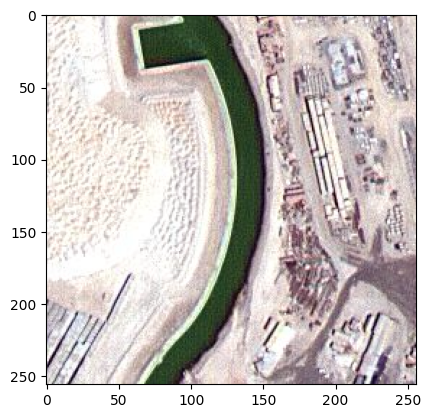

In [ ]:
plt.imshow(imgs[0])

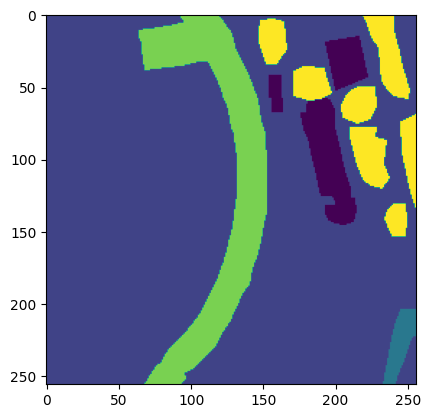

In [ ]:
plt.imshow(masks[0])

## 1. MODEL

The model used was a U-NET structure which makes use of Conv2D layers.

## 2. INPUT

### Preprocessing
Normalization by dividing the pixel values with the maximum.

In [ ]:
# We want our values to be in the range [0,1]

imgs = imgs.astype(np.float32) / 255.0
masks = masks.astype(np.float32) / 5.0

print(f"Min and max pixel values: {imgs.min()}, {imgs.max()}")
print(f"Min and max masks values: {masks.min()}, {masks.max()}")

Min and max pixel values: 0.0, 1.0
Min and max masks values: 0.0, 1.0


Data augmentation by flipping and rotation.

In [ ]:
# Function to augment data with separate flips and rotations
def augment_data(image, mask):
    augmented_images = []
    augmented_masks = []

    # Original
    augmented_images.append(image)
    augmented_masks.append(mask)

    # Vertical flip
    augmented_images.append(np.flipud(image))
    augmented_masks.append(np.flipud(mask))

    # 90 degree rotation
    augmented_images.append(np.rot90(image, k=1))
    augmented_masks.append(np.rot90(mask, k=1))

    return augmented_images, augmented_masks

# Function to apply augmentation to the entire dataset
def augment_dataset(images, masks):
    all_augmented_images = []
    all_augmented_masks = []

    for image, mask in zip(images, masks):
        augmented_images, augmented_masks = augment_data(image, mask)
        all_augmented_images.extend(augmented_images)
        all_augmented_masks.extend(augmented_masks)

    return np.array(all_augmented_images), np.array(all_augmented_masks)

# Apply augmentation to the dataset
augmented_images, augmented_masks = augment_dataset(imgs, masks)

We can see that each input image is a 3D tensor (256, 256, 3).

In [ ]:
print(augmented_images.shape)
print(augmented_masks.shape)

(3915, 256, 256, 3)
(3915, 256, 256, 1)


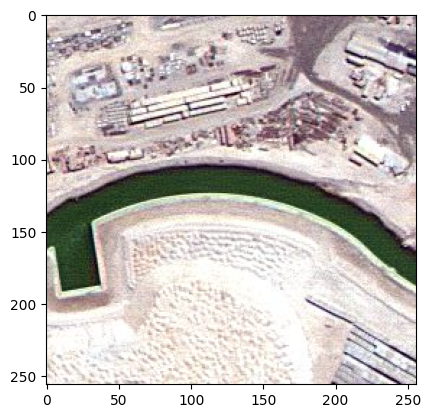

In [ ]:
plt.imshow(augmented_images[2])

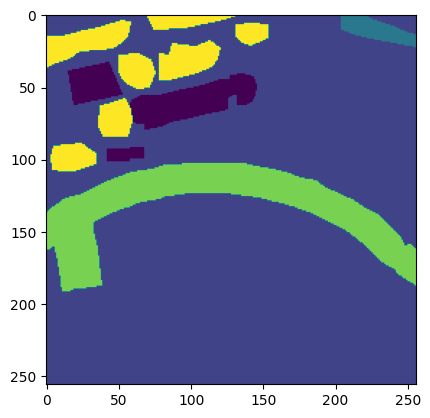

In [ ]:
plt.imshow(augmented_masks[2])

The dataset has been reduced to 2000 samples, after augmentation, due to computational resources.

In [ ]:
def reduce_dataset(x_data, y_data, sample_size):
    # Ensure sample_size is not larger than the dataset
    sample_size = min(sample_size, x_data.shape[0])

    # Generate random indices
    indices = np.random.choice(x_data.shape[0], size=sample_size, replace=False)

    # Subset the data
    x_data_reduced = x_data[indices]
    y_data_reduced = y_data[indices]

    return x_data_reduced, y_data_reduced


sample_size = 2000
images_reduced, masks_reduced = reduce_dataset(augmented_images, augmented_masks, sample_size)

print(f"Reduced dataset size: {images_reduced.shape}, {masks_reduced.shape}")


Reduced dataset size: (2000, 256, 256, 3), (2000, 256, 256, 1)


### Train/Test split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    images_reduced,
    masks_reduced,
    test_size = 0.2,
    random_state = 42
)

## 3. OUTPUT

**CHANGE:** The output has only **1** filter. My written solutions indicated 256 units which is not relevant in this case.\
Because ReLU was used as output activation, a lamba layer was added after to convert the pixels in [0, 5]

```
outputs = Conv2D(1, (1, 1), activation='relu')(conv9)

# Scaling the output to [0, 5]
outputs = Lambda(lambda x: tf.clip_by_value(x * 5, 0, 5))(outputs)
```






## 4. LOSS

MSE was used as loss function.


```
model.compile(
    optimizer=Adam(learning_rate=lr),
    loss='mse'
)
```



## 5. MODEL CONFIGURATION

### Base Model
Base model defined to ensure it works as intended, without any errors.


In [ ]:
# Input layer
inputs = Input(shape=(256, 256, 3))

# Encoder
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
p1 = MaxPooling2D((2, 2)) (c1)

# Bottleneck
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)

# Decoder
u3 = Conv2DTranspose(8, (2, 2), strides=(2,2) ,padding='same') (c2)
u3 = concatenate([u3, c1], axis=3)
c3 = Conv2D(8, (3, 3), activation='relu', padding='same') (u3)

outputs = Conv2D(1, (1, 1),activation='relu', )(c3)
outputs = Lambda(lambda x: tf.clip_by_value(x * 5, 0, 5), output_shape=(256, 256, 1))(outputs)

base_model = Model(inputs=[inputs], outputs=[outputs])

base_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="mse"
)

In [ ]:
history_base = base_model.fit(
    x_train,
    y_train,
    validation_split = 0.2,
    batch_size=32,
    epochs=10
)

### Hyperparameter tuning

The U-NET structure for the model is defined below.\

**CHANGES:**   

*   The output has only **1** filter. My written solutions indicated 256 units which is not relevant in this case.
*   I added skip connections, which I forgot to list in the written solution.
*   There is no flattening/reshaping inplace of a bottleneck layer.





In [ ]:
def build_unet(params):
    input_shape = (256, 256, 3)

    # Extract hyperparameters
    conv1_filters = params['conv1_filters']
    conv2_filters = params['conv2_filters']
    conv3_filters = params['conv3_filters']
    conv4_filters = params['conv4_filters']

    conv5_filters = params['conv5_filters']

    up6_filters = params['up6_filters']
    up7_filters = params['up7_filters']
    up8_filters = params['up8_filters']
    up9_filters = params['up9_filters']

    inputs = Input(shape=input_shape, dtype='float32', name='input')

    # Encoder
    conv1 = Conv2D(conv1_filters, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(conv1_filters, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(conv2_filters, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(conv2_filters, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(conv3_filters, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(conv3_filters, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)

    conv4 = Conv2D(conv4_filters, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(conv4_filters, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)

    # Bottleneck
    conv5 = Conv2D(conv5_filters, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(conv5_filters, (3, 3), activation='relu', padding='same')(conv5)

    # Decoder
    up6 = Conv2DTranspose(up6_filters, (2, 2), strides=(2, 2), padding='same')(conv5)
    up6 = concatenate([up6, conv4], axis=3)
    conv6 = Conv2D(up6_filters, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(up6_filters, (3, 3), activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(up7_filters, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv3], axis=3)
    conv7 = Conv2D(up7_filters, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(up7_filters, (3, 3), activation='relu', padding='same')(conv7)

    up8 = Conv2DTranspose(up8_filters, (2, 2), strides=(2, 2), padding='same')(conv7)
    up8 = concatenate([up8, conv2], axis=3)
    conv8 = Conv2D(up8_filters, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(up8_filters, (3, 3), activation='relu', padding='same')(conv8)

    up9 = Conv2DTranspose(up9_filters, (2, 2), strides=(2, 2), padding='same')(conv8)
    up9 = concatenate([up9, conv1], axis=3)
    conv9 = Conv2D(up9_filters, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(up9_filters, (3, 3), activation='relu', padding='same')(conv9)

    outputs = Conv2D(1, (1, 1), activation='relu')(conv9)
    outputs = Lambda(lambda x: tf.clip_by_value(x * 5, 0, 5), output_shape=(256, 256, 1))(outputs)

    model = Model(inputs=inputs, outputs=outputs)
    return model


In [ ]:
def objective(trial):
    # Defining hyperparameters to tune
    conv1_filters = trial.suggest_int('conv1_filters', 8, 16, step=4)
    conv2_filters = trial.suggest_int('conv2_filters', 12, 20, step=4)
    conv3_filters = trial.suggest_int('conv3_filters', 16, 24, step=4)
    conv4_filters = trial.suggest_int('conv4_filters', 20, 28, step=4)

    conv5_filters = trial.suggest_int('conv5_filters', 24, 32, step=4)

    up6_filters = trial.suggest_int('up6_filters', 20, 28, step=4)
    up7_filters = trial.suggest_int('up7_filters', 16, 24, step=4)
    up8_filters = trial.suggest_int('up8_filters', 12, 20, step=4)
    up9_filters = trial.suggest_int('up9_filters', 8, 16, step=4)

    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)

    print("Trial parameters", trial.params)

    # Build and train the model

    params = {
        'conv1_filters': conv1_filters,
        'conv2_filters': conv2_filters,
        'conv3_filters': conv3_filters,
        'conv4_filters': conv4_filters,
        'conv5_filters': conv5_filters,
        'up6_filters': up6_filters,
        'up7_filters': up7_filters,
        'up8_filters': up8_filters,
        'up9_filters': up9_filters
    }

    model = build_unet(params)

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mse'
    )

    # Train the model
    history = model.fit(
        x_train,
        y_train,
        epochs=10,
        batch_size=32,
        validation_split=0.2
    )

    # Get the best validation loss from the history
    val_loss = min(history.history['val_loss'])  # Get the minimum validation loss

    return val_loss

# Create a study object and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2)  ## Run 2 trials for faster execution

# Print the best hyperparameters
print(study.best_params)

In [ ]:
# Build the best model with the best hyperparameters
best_params = study.best_params

best_model = build_unet(best_params)

best_model.compile(
    optimizer=Adam(learning_rate=best_params['learning_rate']),
    loss='mse'
)

In [ ]:
visualkeras.layered_view(best_model)

## 6. MODEL EVALUATION

In [ ]:
history = best_model.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2
)

In [ ]:
test_loss = best_model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss}")

In [ ]:
# Retrieve metrics from the history object
train_loss = history.history.get('loss', None)
val_loss = history.history.get('val_loss', None)

# Print the last training and validation accuracy
if train_loss and val_loss:
    print(f'Final Training Loss: {train_loss[-1]}')
    print(f'Final Validation Loss: {val_loss[-1]}')
else:
    print("Loss metrics not found in history.")

In [ ]:
# Create a figure and a set of subplots
fig, ax = plt.subplots(1, 1, figsize=(14, 6))  # 1 row, 2 columns

# Plot training & validation loss values
ax.plot(history.history['loss'], label='Training Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.set_title('Model Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(loc='upper left')
ax.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

In [ ]:
# Predict on test data
predictions = best_model.predict(x_test)

# Define thresholds to map normalized values to discrete class labels
thresholds = np.linspace(0, 1, 7)  # 6 thresholds for 6 classes

# Use numpy's digitize to map each value to the appropriate class
pred_discrete = np.digitize(predictions, bins=thresholds, right=True)

# Clip values to be within the range [0, 5]
predictions = np.clip(pred_discrete - 1, 0, 5)

# Print the shape of the predictions
print(predictions.shape)

def display_sample_multiclass(x, y, pred, index):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title('Image')
    plt.imshow(x[index])
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('True Mask')
    plt.imshow(y[index])
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Predicted Mask')
    plt.imshow(pred[index])
    plt.axis('off')

    plt.show()

# Display a few examples for multi-class segmentation
for i in range(10):
    display_sample_multiclass(x=x_test, y=y_test, pred=predictions, index=i)